In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# import and normalize data

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure the images are in greyscale
    transforms.Resize((128, 128)),  
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize with mean and std for greyscale
])


In [4]:
# adding another convolutional layer block (total of 5 blocks)

class TinyVGG5(nn.Module):
    def __init__(self, num_classes):
        super(TinyVGG5, self).__init__()
        
        self.conv_layers = nn.Sequential(
            # Convolutional Layer Block 1
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 128 -> 64

            # Convolutional Layer Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 64 -> 32

            # Convolutional Layer Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32 -> 16

            # Convolutional Layer Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 16 -> 8

            # Convolutional Layer Block 5
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 8 -> 4
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 4 * 4, 512), 
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

Image: Screenshot 2024-08-03 162822.png, Predicted: happiness


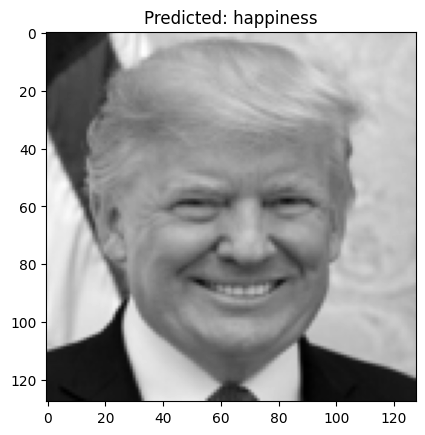

Image: Screenshot 2024-08-03 163041.png, Predicted: anger


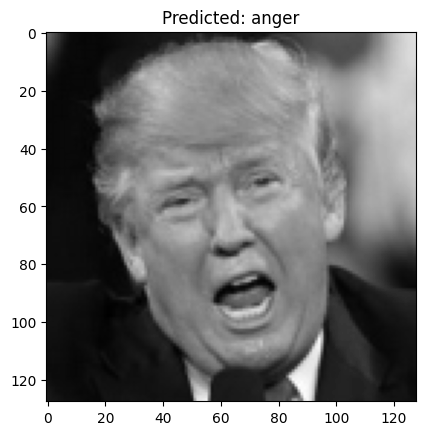

Image: Screenshot 2024-08-03 163457.png, Predicted: happiness


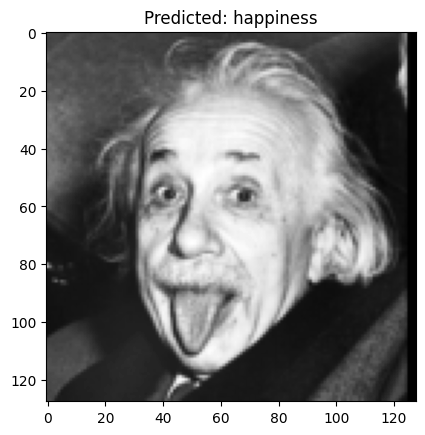

Image: Screenshot 2024-08-03 163548.png, Predicted: neutral


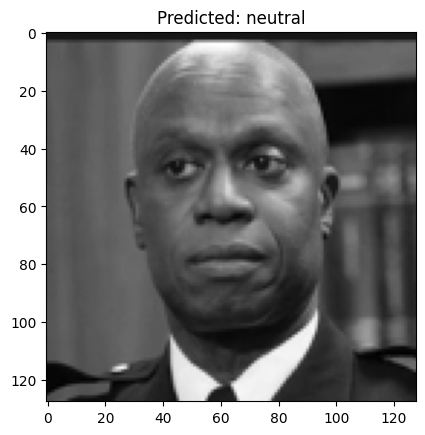

In [5]:
import os 
from PIL import Image


model = TinyVGG5(num_classes=8)
model.load_state_dict(torch.load('tiny_VGG.pth'))
model = model.to(device)
model.eval()

test_folder = './custom_test'
classes = ['anger',
 'contempt',
 'disgust',
 'fear',
 'happiness',
 'neutral',
 'sadness',
 'surprise']

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5])
    std = np.array([0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp, cmap='gray')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

for image_name in os.listdir(test_folder):
    if image_name.endswith(('.png', '.jpg', '.jpeg')):  # Check for valid image extensions
        image_path = os.path.join(test_folder, image_name)
        image = Image.open(image_path)

        # Apply transformations to the image
        input_tensor = transform(image)
        input_tensor = input_tensor.unsqueeze(0)  # Add batch dimension
        input_tensor = input_tensor.to(device)

        # Perform inference
        with torch.no_grad():
            output = model(input_tensor)
            _, predicted = torch.max(output, 1)
            predicted_label = classes[predicted[0]]

        # Display the image and the predicted label
        print(f'Image: {image_name}, Predicted: {predicted_label}')
        imshow(torch.Tensor.cpu(input_tensor[0]), title=f'Predicted: {predicted_label}')
        plt.show()

In [6]:
# import dependencies
import cv2 
import numpy as np
import torch

# initialize the Haar Cascade face detection model 
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
print("Face Detection Model Loaded Successfully")

emotion_dict = {0: "Angry", 1: "Contempt", 2: "Disgust", 3: "Fear", 4: "Happy", 5: "Neutral", 6: "Sad", 7: "Surprise"} 

# torch.device('mps')

model = TinyVGG5(num_classes=8).to(device)
model.load_state_dict(torch.load('Tiny_VGG.pth', map_location=torch.device(device)))
print("Recognition Model Loaded Successfully")

# Start the webcam
cap = cv2.VideoCapture(0)
cap.set(3,640) # set Width
cap.set(4,480) # set Height

while True:
    ret, frame = cap.read()
    if not ret:
        break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        roi_gray = gray[y:y+h, x:x+w]
        cropped_img = cv2.resize(roi_gray, (128, 128))
        img_tensor = torch.tensor(cropped_img).float().unsqueeze(0).unsqueeze(0)
        img_tensor = img_tensor/255.0
        img_tensor = img_tensor.to(device)
        with torch.no_grad():
            outputs = model(img_tensor)

        _, predicted = torch.max(outputs.data, 1)
        cv2.putText(frame, emotion_dict[predicted.item()], (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.imshow('frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Face Detection Model Loaded Successfully
Recognition Model Loaded Successfully
